# Vehicle classification App

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/AnyoneAI/sprint4_2"
    %cd $ROOT_DIR

/content/drive/.shortcut-targets-by-id/1yhgPiTqQV0XxnwRPCFF1FG7wBH2p5Lwn/AnyoneAI/sprint4_2


## Install dependencies (Only for Colab)

In [5]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.0 MB/s eta 0:00:00


# 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [6]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from src import data_utils, models, config

### Getting the data

To access the data for this project, you only need to execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. You will not need these files unless you want to solve the optional exercises.


1.1. Download the training and test datasets.

In [7]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/dataset/"

data_utils.download_datasets(config.DATASET_ROOT_PATH)


Downloading...
From: https://drive.google.com/uc?id=1ueaI8NJLS73Eq8Kx9ctdy5hK3vD53_Jb&confirm=t
To: /content/dataset/cars_25_dataset.zip
100%|██████████| 116M/116M [00:05<00:00, 22.4MB/s]


1.2. Setup some variables you will use during training the model.

The default values used here should work fine for you.

In [8]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224  # Set your desired image height
img_width = 224  # Set your desired image width
batch_size = 32  # Set your desired batch size

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

Note that it's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [9]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),  # Where data is located
    labels="inferred",  # Labels are generated from the directory structure (subdirectories)
    label_mode="categorical",  # Encode one-hot vectors.
    seed=123,  # Optional random seed for shuffling and transformations.
    image_size=(img_height, img_width),
    batch_size=batch_size,  # Size of the batches of data.
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

# 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.

---

`class_names` --> Only valid if "labels" is "inferred". This is the explicit list of class names (must match names of subdirectories). Used to control the order of the classes (otherwise alphanumerical order is used).

---

Make sure to adjust the `25` in the `assert` statement to the actual number of classes in your dataset. This assertion will ensure that the number of class names matches your expectations.

By printing the `class_names`, you can verify that the labels have been correctly inferred and that the class names correspond to the subdirectory names in your training dataset.

In [10]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

In this code, we iterate over the first batch of images and labels from the `train_ds` dataset using `train_ds.take(1)`. Then, within the nested loop, we plot each image using `plt.imshow`, convert the image tensor to a numpy array using `.numpy()`, and set the data type to `uint8` with `.astype("uint8")`.

We use `np.argmax(labels[i])` to find the index of the maximum value in the label vector, representing the predicted class. This index is used to retrieve the corresponding class name from the `class_names` list.

The `plt.title` function sets the title of each subplot as the corresponding class name, and `plt.axis("off")` hides the axes and ticks.

Finally, we use `plt.show()` to display the grid of images with their labels.

Make sure you have imported the necessary libraries, including `matplotlib.pyplot` and `numpy`, for this code to work properly.

Let me know if there's anything else I can assist you with!

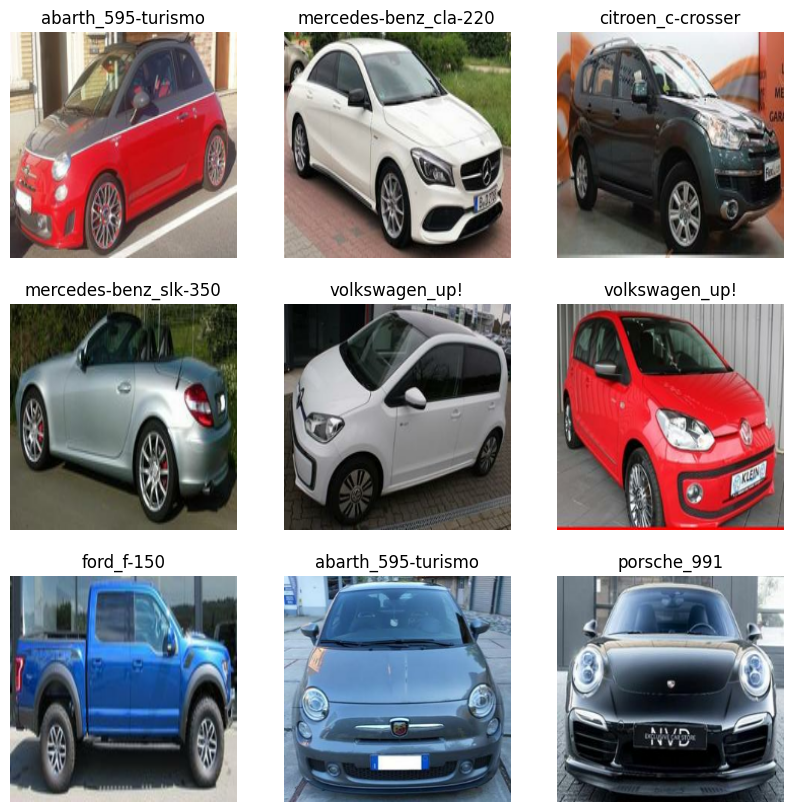

In [ ]:
# Display a grid of 9 images from the training dataset along with their corresponding labels.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

Let's break down what each method does:

- `cache()`: This method caches the data in memory after the first epoch. Caching the data helps to improve training speed in subsequent epochs since the data doesn't need to be loaded from disk again. It is particularly useful if you have enough memory to store the entire dataset.

- `shuffle(1000)`: This method shuffles the training dataset with a buffer size of 1000. The buffer size determines the number of elements randomly selected from the dataset to form a new batch. Shuffling the data helps to reduce the impact of any ordering or bias in the dataset during training.

- `prefetch(buffer_size=AUTOTUNE)`: This method overlaps the data preprocessing and model execution. It prefetches data batches from disk into memory while the model is training on the current batch. Using `AUTOTUNE` as the buffer size allows TensorFlow to automatically tune the buffer size based on the available system resources to achieve the best performance.

By applying these techniques, you can optimize the data loading and preprocessing pipeline, minimizing the time spent waiting for data during model training.

Let me know if there's anything else I can help you with!

In [11]:
# Configure data loader for better performance by utilizing caching and prefetching techniques.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# 3. Multi-layer Perceptron

*Now it's time to train our  Neural Network model*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

- Perceptron (YouTube): https://youtu.be/4Gac5I64LM4
- Adam: A Method for Stochastic Optimization: https://arxiv.org/abs/1412.6980
- 134 - What are Optimizers in deep learning? (Keras & TensorFlow): https://youtu.be/JhQqquVeCE0?list=PLZsOBAyNTZwZusFFxso3rZNRN_a1llepp


---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


The `input_shape` of a model is the shape of the data that the model will be trained on. In this case, the data is images, so the `input_shape` is `(img_height, img_width, 3)`. This means that each image is a 2D array with height and width, and each pixel in the image is a 3D array with red, green, and blue channels.

The Adam optimizer is an optimization algorithm commonly used in deep learning for training neural networks. The name "Adam" stands for Adaptive Moment Estimation. It combines the concepts of adaptive learning rates and momentum to achieve efficient and effective optimization.

Here's a brief overview of how the Adam optimizer works:

1. **Adaptive Learning Rates**: Adam adjusts the learning rate for each parameter in the neural network based on the estimated first and second moments of the gradients. It calculates adaptive learning rates that are specific to each parameter and updates them accordingly during the training process.

2. **Momentum**: Adam also incorporates the concept of momentum, which helps accelerate convergence and overcome obstacles such as local minima. Momentum allows the optimizer to accumulate a weighted average of past gradients and use it to update the parameters. This helps the optimizer to move more quickly in the relevant directions and dampen oscillations.

3. **Bias Correction**: During the early training stages, the estimates of the first and second moments are biased towards zero because of the initialization. Adam corrects these biases by calculating bias-corrected first and second moment estimates, which leads to more accurate updates.

Overall, the adaptive learning rates and momentum in Adam make it suitable for a wide range of optimization problems. It can handle sparse gradients, noisy data, and large parameter spaces effectively. Adam has become a popular choice due to its robustness and good convergence properties.

When using the Adam optimizer in TensorFlow, you can specify the learning rate through the `learning_rate` parameter, as demonstrated in the code snippet you provided:

```python
optimizer=keras.optimizers.Adam(learning_rate=5e-6)
```

The learning rate determines the step size at each iteration of the optimization process. Smaller learning rates can help converge to a good solution but may require more time for training, while larger learning rates can make training faster but may result in unstable convergence.

In [ ]:
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

import matplotlib.pyplot as plt

history = mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
)

# Evaluating the model
# train_ds, test_ds

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_9 (Dense)             (None, 512)               77070848  
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dense_12 (Dense)            (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785


# Training accuracy and Validation accuracy chart

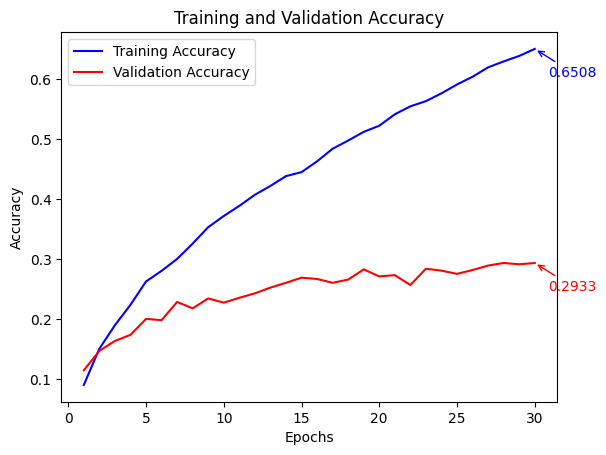

In [ ]:
# Get the training accuracy and validation accuracy values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

# Add accuracy values as text annotations at the end of the line chart
plt.annotate(
    f"{training_accuracy[-1]:.4f}",
    xy=(epochs[-1], training_accuracy[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{validation_accuracy[-1]:.4f}",
    xy=(epochs[-1], validation_accuracy[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()

# Loss and Validation loss chart

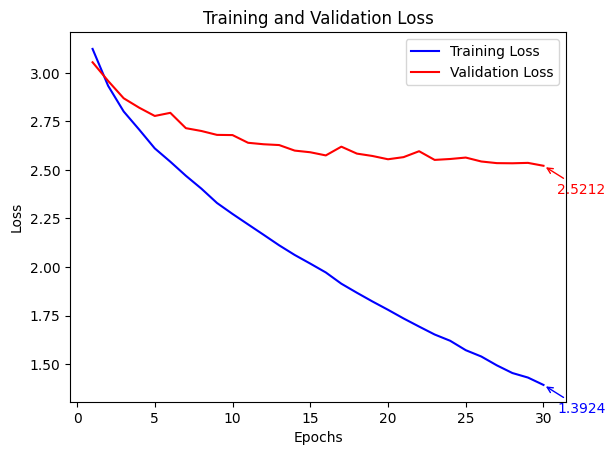

In [ ]:
# Get the loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add loss values as text annotations at the end of the line chart
plt.annotate(
    f"{loss[-1]:.4f}",
    xy=(epochs[-1], loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(epochs[-1], val_loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

This difference between training and validation performance suggests that the model may be overfitting, meaning it is too specialized to the training data and not generalizing well to new data. To address overfitting, one can consider techniques like regularization (e.g., adding dropout layers) or adjusting the model architecture to reduce complexity.

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

I can try adding callbacks

# MLP With Callbacks (Checkpoint, reduce LR and early stopping)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define callbacks
# Save the best weights
checkpoint = ModelCheckpoint("best_weights.h5", save_best_only=True)
# Reducin LR by 0.1 every 2 epochs that platoes
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=1e-7, verbose=1)
# Stop training after platoing for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


history = mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

### I can then use the weights I saved with the mlp_model architecture as follows:

In [ ]:
import tensorflow as tf

# Cargar el modelo guardado
loaded_model = tf.keras.models.load_model("best_weights.h5")
loaded_model.trainable=True

# Verificar la estructura y los parámetros del modelo cargado
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

# Training and Validation Accuracy graphs

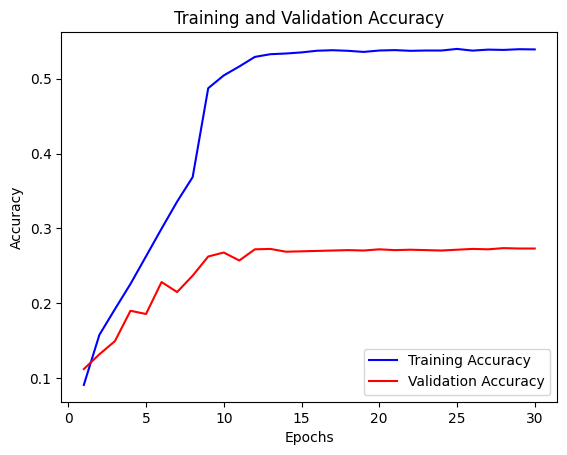

In [ ]:
# Get the training accuracy and validation accuracy values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss and Validation loss chart

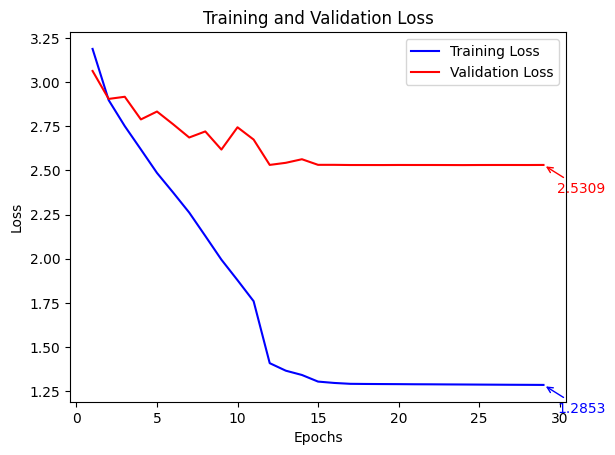

In [ ]:
# Get the loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add loss values as text annotations at the end of the line chart
plt.annotate(
    f"{loss[-1]:.4f}",
    xy=(epochs[-1], loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(epochs[-1], val_loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define callbacks
# Save the best weights
checkpoint = ModelCheckpoint("best_weights_lenet.h5", save_best_only=True)
# Reducin LR by 0.1 every 2 epochs that platoes
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=1e-7, verbose=1)
# Stop training after platoing for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_lenet = lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)            

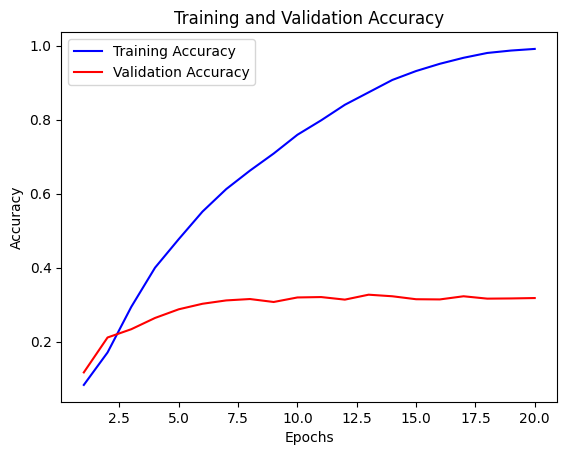

In [ ]:
# Evaluating the model
# train_ds, test_ds

# Get the training accuracy and validation accuracy values from the history object
training_accuracy_lenet = history_lenet.history['accuracy']
validation_accuracy_lenet = history_lenet.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy_lenet) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy_lenet, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_lenet, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

At this point the model accuracy in the validation dataset should be around *0.3*.

- **What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?**


There is a big difference between training and validation performance which suggests that the model may be overfitting, but at least is learning something.

- **What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?**

Some techniques to address overfitting can be techniques like regularization like adding dropout layers or reducing the model complexity.

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)


history_resnet = resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    callbacks=[early_stopping],
)


94781440/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/40
235/235 [==============================] - 51s 136ms/step - loss: 5.6360 - accuracy: 0.

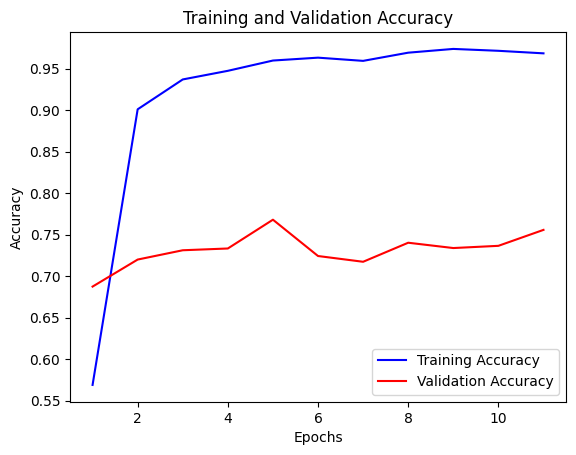

In [ ]:
# Evaluating the model
# train_ds, test_ds

# Get the training accuracy and validation accuracy values from the history object
training_accuracy_resnet = history_resnet.history['accuracy']
validation_accuracy_resnet = history_resnet.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy_resnet) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy_resnet, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_resnet, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The `ModelCheckpoint` callback allows you to specify a file path where the best model will be saved based on a monitored metric, such as validation accuracy.

In this code, we import the `ModelCheckpoint` callback from `tensorflow.keras.callbacks`. We define a checkpoint path (e.g., "best_model.h5") where the best model weights will be saved. The monitor parameter is set to "val_accuracy" to track the validation accuracy and determine the best model. The `save_best_only` parameter is set to True to save only the best model based on the monitored metric. The `save_weights_only` parameter is set to True to save only the weights of the model rather than the entire model. The `verbose` parameter is set to `1` to display a message when the best model is saved.

Now, the best model weights will be saved to the specified file path whenever an improvement in validation accuracy is observed. You can load these saved weights later to make predictions or further fine-tuning.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define the checkpoint path
checkpoint_path = "best_model_resnet50.h5"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(checkpoint_path,monitor="val_accuracy",mode="max",save_best_only=True,save_weights_only=True,verbose=1)

history_resnet = resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[checkpoint_callback],
)

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 5.6239 - accuracy: 0.0719
Ep

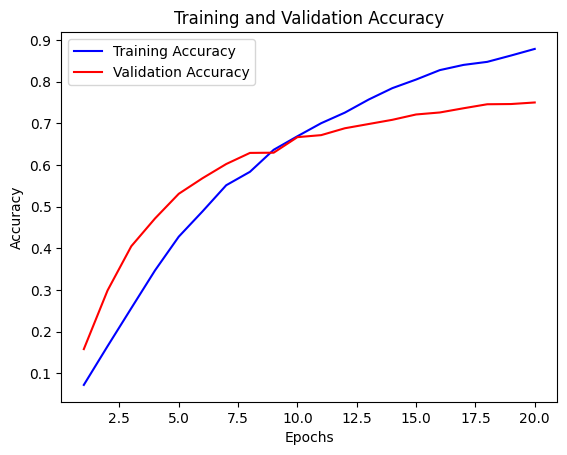

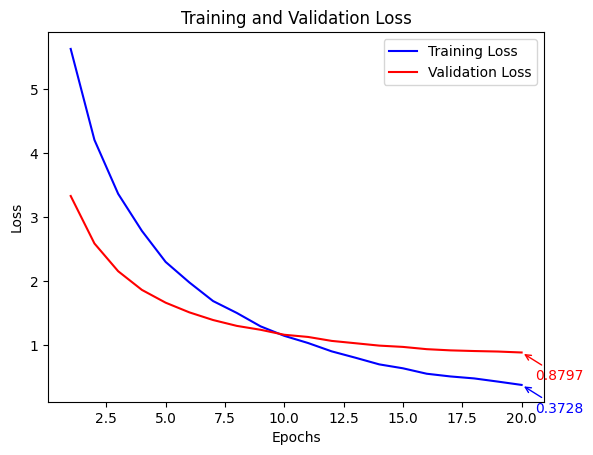

In [ ]:
# Evaluating the model
# train_ds, test_ds

# ACCURACY
# Get the training accuracy and validation accuracy values from the history object
training_accuracy_resnet = history_resnet.history['accuracy']
validation_accuracy_resnet = history_resnet.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy_resnet) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy_resnet, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_resnet, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LOSS
# Get the loss and validation loss from the training history
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add loss values as text annotations at the end of the line chart
plt.annotate(
    f"{loss[-1]:.4f}",
    xy=(epochs[-1], loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(epochs[-1], val_loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()



# ResNet50 with Preprocess and ReduceLROnPlateau, ModelCheckpoint

In this part of the code, the `map()` function is used to apply a preprocessing step to each image in the training and testing datasets.

The `map()` function takes a lambda function as an argument and applies that function to each element of the dataset. In this case, the lambda function takes two inputs `(x, y)`, where `x` represents the image and `y` represents the label.

Within the lambda function, `resnet_preprocess_input(x)` is called to preprocess the image `x` using the `preprocess_input` function from the ResNet50 model. This preprocessing step is specific to the ResNet50 model and is used to ensure that the input images are formatted in a way that the model expects.

So, the line `train_ds_preprocessed = train_ds.map(lambda x, y: (resnet_preprocess_input(x), y))` applies the preprocessing step to each image in the training dataset, and the line `test_ds_preprocessed = test_ds.map(lambda x, y: (resnet_preprocess_input(x), y))` applies the same preprocessing step to each image in the testing dataset.

By performing this preprocessing step, the images are transformed in a way that is compatible with the ResNet50 model, allowing for more accurate predictions when the model is trained and evaluated on these preprocessed datasets.

I hope this explanation clarifies the purpose of this part of the code.

In [ ]:
# Preprocesses a tensor or Numpy array encoding a batch of images.
# Returns:
#     Preprocessed numpy.array or a tf.Tensor with type float32.
#     The images are converted from RGB to BGR, then each color channel is
#     zero-centered with respect to the ImageNet dataset, without scaling.

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

resnet50_model_pre = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Define callbacks
# ModelCheckpoint callback saves the best weights of the model during training
checkpoint = ModelCheckpoint("best_weights_resnet50_2.h5",monitor="val_accuracy",mode="max",save_best_only=True,save_weights_only=True,verbose=1)

# ReduceLROnPlateau callback reduces the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Metric to monitor for improvement
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,  # Lower bound on the learning rate
    verbose=1  # Print a message when the learning rate is reduced
)

# Compile the model with an initial learning rate
resnet50_model_pre.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Specify the optimizer and learning rate
    loss="categorical_crossentropy",  # Specify the loss function
    metrics=["accuracy"]  # Specify the metrics to evaluate during training
)

# Preprocess the training and testing datasets using the ResNet50 preprocess_input function
train_ds_preprocessed = train_ds.map(lambda x, y: (resnet_preprocess_input(x), y)) # prepare the data for resnet50
test_ds_preprocessed = test_ds.map(lambda x, y: (resnet_preprocess_input(x), y)) # prepare the data for resnet50

# Fit the model to the preprocessed training dataset and evaluate on the preprocessed testing dataset
history_resnet_preprocess = resnet50_model_pre.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=30,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=5,  # Stop training if no improvement in validation loss after 5 epochs
            restore_best_weights=True  # Restore the best weights from the training
        ),
        checkpoint,  # Save the best weights of the model
        reduce_lr  # Reduce the learning rate during training
    ]
)

# Evaluating the model
# train_ds, test_ds



94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 3.0711 - accuracy: 0.3618
Ep

In [ ]:
import tensorflow as tf

# Cargar el modelo guardado
loaded_model = tf.keras.models.load_model("best_weights.h5")


# Verificar la estructura y los parámetros del modelo cargado
loaded_model.summary()

### Training accuracy and Validation accuracy chart

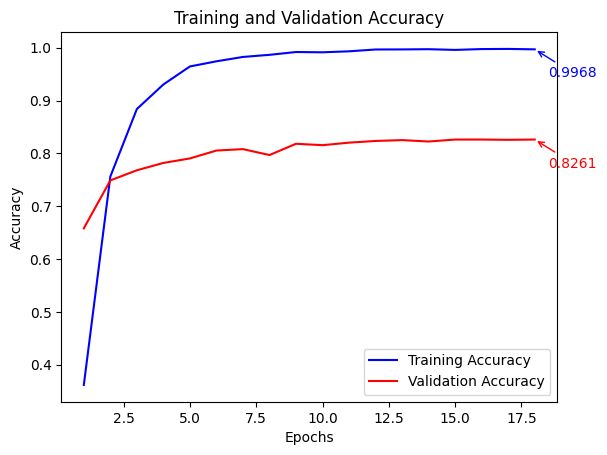

In [ ]:
# Get the training accuracy and validation accuracy values from the history object
training_accuracy_resnet_pre = history_resnet_preprocess.history['accuracy']
validation_accuracy_resnet_pre = history_resnet_preprocess.history['val_accuracy']

# Generate a range of epoch numbers for the x-axis
epochs = range(1, len(training_accuracy_resnet_pre) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_accuracy_resnet_pre, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_resnet_pre, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

# Add accuracy values as text annotations at the end of the line chart
plt.annotate(
    f"{training_accuracy_resnet_pre[-1]:.4f}",
    xy=(epochs[-1], training_accuracy_resnet_pre[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{validation_accuracy_resnet_pre[-1]:.4f}",
    xy=(epochs[-1], validation_accuracy_resnet_pre[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()

### Loss and Validation loss chart

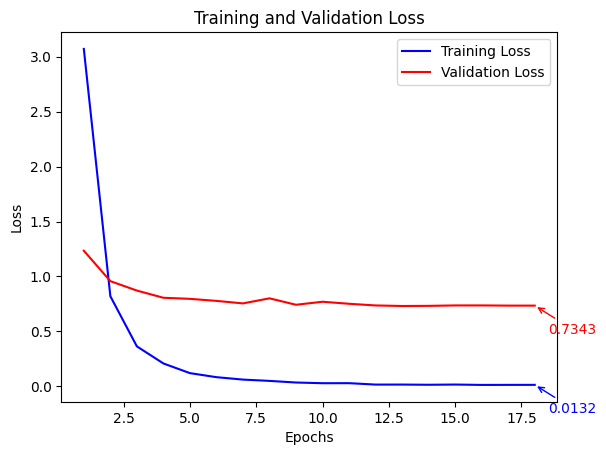

In [ ]:
# Get the loss and validation loss from the training history
loss = history_resnet_preprocess.history['loss']
val_loss = history_resnet_preprocess.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add loss values as text annotations at the end of the line chart
plt.annotate(
    f"{loss[-1]:.4f}",
    xy=(epochs[-1], loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="b"),
    color="b",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(epochs[-1], val_loss[-1]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1, color="r"),
    color="r",
)

plt.show()

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

# 6. Analyze model results

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


In [ ]:
# I will reuse the weights previously optimized

resnet50_model_reload = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)
resnet50_model_reload.load_weights('best_weights_resnet50_2.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None


Let's break down the code step by step:

1. `y_pred = resnet50_model_pre.predict(test_ds)`: This line predicts the output probabilities for the test dataset (`test_ds`) using the trained model (`resnet50_model_pre`). It generates predictions for each input sample in the test dataset.

2. `predicted_categories = np.argmax(y_pred, axis=1)`: Here, `np.argmax()` is used to find the index of the highest probability in each predicted output vector (`y_pred`). It returns an array (`predicted_categories`) containing the predicted category labels for each input sample in the test dataset.

3. `true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()`: This line concatenates the true category labels (`y`) from the test dataset (`test_ds`) along the 0th axis. It iterates through each element (`x, y`) in the `test_ds` dataset using a list comprehension and extracts the true category labels (`y`). Finally, the result is converted to a NumPy array using the `.numpy()` method.

4. `true_categories_argmax = np.argmax(true_categories, axis=1)`: Similarly to step 2, `np.argmax()` is applied to the true category labels (`true_categories`) to find the index of the highest value in each label vector. It returns an array (`true_categories_argmax`) containing the true category labels encoded as numerical indices.

In summary, this code segment calculates the predicted category labels (`predicted_categories`) and true category labels (`true_categories_argmax`) for the test dataset, which will be useful for further evaluation and analysis of the model's performance.

In [ ]:
# Predict the output probabilities for the test dataset using the trained model
y_pred = resnet50_model_reload.predict(test_ds)

# Find the index of the highest probability in each predicted output vector
predicted_categories = np.argmax(y_pred, axis=1)

# Concatenate the true category labels from the test dataset along the 0th axis
true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()

# Find the index of the highest value in each true category label vector
true_categories_argmax = np.argmax(true_categories, axis=1)

# Map the true indices to their corresponding class names
true_labels = [class_names[i] for i in true_categories_argmax]

This code calculates and plots the Receiver Operating Characteristic (ROC) curves for each class in the classification problem. It uses the true category labels (`true_categories`) and the predicted output probabilities (`y_pred`) to calculate the false positive rate (FPR) and true positive rate (TPR) for each class. The Area Under the Curve (AUC) is also calculated for each ROC curve, and the results are stored in dictionaries. Finally, the ROC curves are plotted with the corresponding AUC values, along with a diagonal line representing the random classifier.

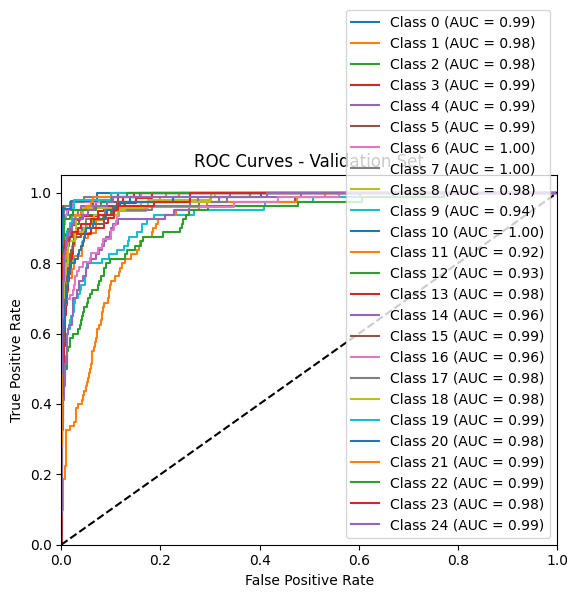

In [ ]:
# Import necessary functions and classes from scikit-learn
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Create empty dictionaries to store the results
fpr_val = {}
tpr_val = {}
roc_auc_val = {}

# Iterate over each class index (assuming there are 25 classes)
for class_idx in range(25):
    # Calculate the ROC curve for the current class
    fpr, tpr, _ = roc_curve(true_categories[:, class_idx], y_pred[:, class_idx])

    # Calculate the Area Under the Curve (AUC) for the ROC curve
    roc_auc = auc(fpr, tpr)

    # Store the results in the respective dictionaries
    fpr_val[class_idx] = fpr
    tpr_val[class_idx] = tpr
    roc_auc_val[class_idx] = roc_auc

    # Plot the ROC curve for the current class with the corresponding AUC value
    plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

# Plot a diagonal line representing the random classifier
plt.plot([0, 1], [0, 1], 'k--')

# Set the x-axis and y-axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title and add a legend to the plot
plt.title('ROC Curves - Validation Set')
plt.legend(loc="lower right")

# Display the plot
plt.show()

In [ ]:
print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

                              precision    recall  f1-score   support

          abarth_595-turismo       0.85      0.93      0.89        80
         abarth_grande-punto       0.92      0.63      0.75        78
                      bmw_z4       0.67      0.90      0.77        80
           citroen_c-crosser       0.76      0.88      0.81        77
                 citroen_ds4       0.79      0.86      0.83        80
                citroen_nemo       0.79      0.96      0.87        80
                 dacia_lodgy       0.77      0.94      0.85        80
                  ford_f-150       0.87      0.94      0.90        80
               hyundai_h-350       0.89      0.67      0.77        46
                 hyundai_i30       0.81      0.44      0.57        80
land-rover_range-rover-velar       0.91      0.93      0.92        43
           mercedes-benz_180       0.45      0.33      0.38        80
         mercedes-benz_a-180       0.67      0.51      0.58        80
         mercedes-b

<Axes: >

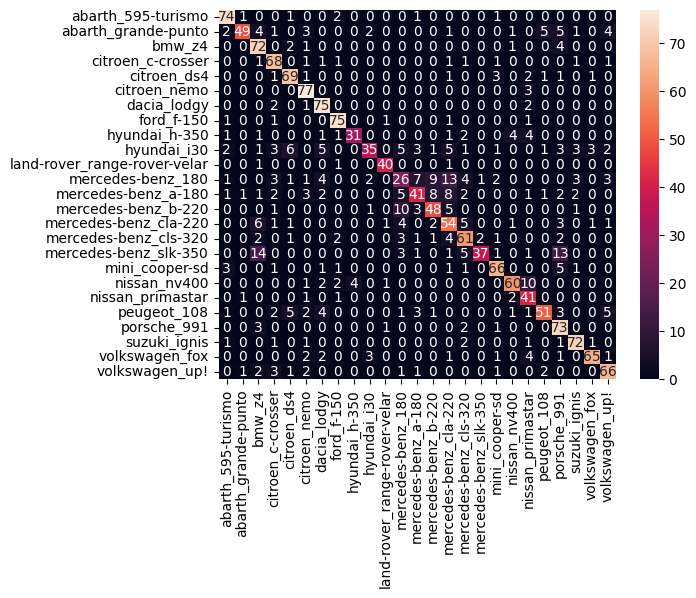

In [ ]:
# CONFUSION MATRIX

import seaborn as sns

matrix=tf.math.confusion_matrix(true_categories_argmax, predicted_categories)
sns.heatmap(matrix,  annot=True, xticklabels=class_names, yticklabels=class_names)

# 7. EfficientNetB7 & EfficientNetB1

The models we've trained before are just a limited set over the universe of stuff we can use.

There are still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.

Here I will experiment with EfficientNetB7 and EfficientNetB1 with data augmentation

### EfficientNetB7

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# Do the data augmentation
datagenerator = ImageDataGenerator(
    rotation_range=30,  # Random rotations up to 30 degrees
    width_shift_range=0.3,  # Random horizontal shifts within 20% of the image width
    height_shift_range=0.3,  # Random vertical shifts within 20% of the image height
    shear_range=0.4,  # Random shear transformations within 20% intensity
    zoom_range=0.4,  # Random zooming up to 20% of the original size
    horizontal_flip=True,  # Randomly flip the image horizontally
    vertical_flip=True,  # Randomly flip the image vertically
    brightness_range=[0.2, 2],  # Random brightness adjustments between 0.8 and 1.2
    fill_mode='nearest'  # Fill in newly created pixels with the value of the nearest pixel
)

# for the validation set no augmentation is applied
valid_datagen = ImageDataGenerator()

# Define the input shape and number of classes
input_shape = (600, 600, 3)
num_classes = len(class_names)

# Set EfficientNetB7 model
B7_model = EfficientNetB7(include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

for layer in B7_model.layers:
        layer.trainable = False

# Make de architecture
model=keras.Sequential([
    B7_model, #model
    keras.layers.GlobalMaxPooling2D(), #Reduce spatial dimensions
    keras.layers.Dense(25, activation='softmax') #25 outputs and softmax
])


optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Create the augmented training data
train_aug=datagenerator.flow_from_directory(
    os.path.join(DATASET_FOLDER, "train"), # Path
    target_size=(600,600), # Reshape images
    batch_size=32, # Number of images per batch
    class_mode='categorical', # Categorical is best for multi-class classification
    shuffle=True
)

validation_aug=valid_datagen.flow_from_directory(
    os.path.join(DATASET_FOLDER, "test"), # Path
    target_size=(600,600), # Reshape images
    batch_size=32, # Number of images per batch
    class_mode='categorical', # Categorical is best for multi-class classification
    shuffle=True
)


Found 7509 images belonging to 25 classes.
Found 1875 images belonging to 25 classes.


In [ ]:

batch_size=32

B7_history=model.fit(
    train_aug,
    steps_per_epoch=train_aug.n // batch_size,
    epochs=20,
    validation_data=validation_aug,
    validation_steps=validation_aug.n // batch_size
)



Epoch 1/20
234/234 [==============================] - 225s 874ms/step - loss: 2.8301 - accuracy: 0.2889 - val_loss: 1.4285 - val_accuracy: 0.5738
Epoch 2/20
234/234 [==============================] - 197s 840ms/step - loss: 1.1879 - accuracy: 0.6333 - val_loss: 0.7334 - val_accuracy: 0.7705
Epoch 3/20
234/234 [==============================] - 196s 835ms/step - loss: 0.8075 - accuracy: 0.7573 - val_loss: 0.4580 - val_accuracy: 0.8459
Epoch 4/20
234/234 [==============================] - 198s 845ms/step - loss: 0.6572 - accuracy: 0.7935 - val_loss: 0.7794 - val_accuracy: 0.7737
Epoch 5/20
234/234 [==============================] - 200s 852ms/step - loss: 0.6052 - accuracy: 0.8130 - val_loss: 0.3768 - val_accuracy: 0.8820
Epoch 6/20
234/234 [==============================] - 198s 843ms/step - loss: 0.5159 - accuracy: 0.8347 - val_loss: 0.3928 - val_accuracy: 0.8782
Epoch 7/20
234/234 [==============================] - 197s 843ms/step - loss: 0.4823 - accuracy: 0.8502 - val_loss: 0.4418 -

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Do the data augmentation
datagenerator = ImageDataGenerator(
    rotation_range=30,  # Random rotations up to 30 degrees
    width_shift_range=0.3,  # Random horizontal shifts within 20% of the image width
    height_shift_range=0.3,  # Random vertical shifts within 20% of the image height
    shear_range=0.4,  # Random shear transformations within 20% intensity
    zoom_range=0.4,  # Random zooming up to 20% of the original size
    horizontal_flip=True,  # Randomly flip the image horizontally
    vertical_flip=True,  # Randomly flip the image vertically
    brightness_range=[0.2, 2],  # Random brightness adjustments between 0.8 and 1.2
    fill_mode='nearest'  # Fill in newly created pixels with the value of the nearest pixel
)

# for the validation set no augmentation is applied
valid_datagen = ImageDataGenerator()

# Create the augmented training data
train_aug=datagenerator.flow_from_directory(
    os.path.join(DATASET_FOLDER, "train"), # Path
    target_size=(240,240), # Reshape images
    batch_size=32, # Number of images per batch
    class_mode='categorical', # Categorical is best for multi-class classification
    shuffle=False
)

validation_aug=valid_datagen.flow_from_directory(
    os.path.join(DATASET_FOLDER, "test"), # Path
    target_size=(240,240), # Reshape images
    batch_size=32, # Number of images per batch
    class_mode='categorical', # Categorical is best for multi-class classification
    shuffle=False
)

Found 7509 images belonging to 25 classes.
Found 1875 images belonging to 25 classes.


### EfficientNetB1

In [13]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Define the input shape and number of classes
input_shape = (240, 240, 3)
num_classes = len(class_names)

# Set EfficientNetB1 model
B1_model = EfficientNetB1(include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

for layer in B1_model.layers:
  layer.trainable = True

# Make de architecture
model=keras.Sequential([
    B1_model, #model
    keras.layers.GlobalMaxPooling2D(), #Reduce spatial dimensions
    keras.layers.Dense(25, activation='softmax') #25 outputs and softmax
])


model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
earlystoping=EarlyStopping(
            patience=5,  # Stop training if no improvement in validation loss after 5 epochs
            restore_best_weights=True  # Restore the best weights from the training
        )
checkpoint = ModelCheckpoint(
    "best_weights_B1.h5",
     save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Metric to monitor for improvement
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,  # Lower bound on the learning rate
    verbose=1  # Print a message when the learning rate is reduced
)

In [ ]:
batch_size=32

B1_history=model.fit(
    train_aug,
    steps_per_epoch=train_aug.n // batch_size,
    epochs=30,
    validation_data=validation_aug,
    validation_steps=validation_aug.n // batch_size,
    callbacks=[earlystoping,checkpoint,reduce_lr],
)


Epoch 1/30
234/234 [==============================] - 211s 847ms/step - loss: 3.0632 - accuracy: 0.2676 - val_loss: 1.1966 - val_accuracy: 0.6293 - lr: 5.0000e-04
Epoch 2/30
234/234 [==============================] - 204s 870ms/step - loss: 1.2343 - accuracy: 0.6255 - val_loss: 0.6246 - val_accuracy: 0.8055 - lr: 5.0000e-04
Epoch 3/30
234/234 [==============================] - 203s 867ms/step - loss: 0.7833 - accuracy: 0.7607 - val_loss: 0.4089 - val_accuracy: 0.8718 - lr: 5.0000e-04
Epoch 4/30
234/234 [==============================] - 196s 837ms/step - loss: 0.5963 - accuracy: 0.8146 - val_loss: 0.3880 - val_accuracy: 0.8782 - lr: 5.0000e-04
Epoch 5/30
234/234 [==============================] - 189s 806ms/step - loss: 0.5117 - accuracy: 0.8378 - val_loss: 0.3556 - val_accuracy: 0.8852 - lr: 5.0000e-04
Epoch 6/30
234/234 [==============================] - 188s 804ms/step - loss: 0.4429 - accuracy: 0.8584 - val_loss: 0.2506 - val_accuracy: 0.9181 - lr: 5.0000e-04
Epoch 7/30
234/234 [==

### Training & Validation Loss

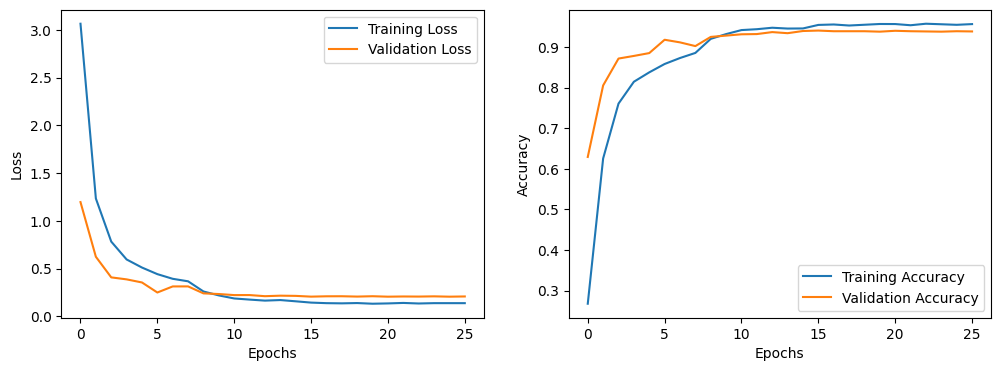

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(B1_history.history['loss'], label='Training Loss')
plt.plot(B1_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(B1_history.history['accuracy'], label='Training Accuracy')
plt.plot(B1_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# I will reuse the weights previously optimized
model.load_weights('best_weights_B1.h5')

### Confusion Matrix

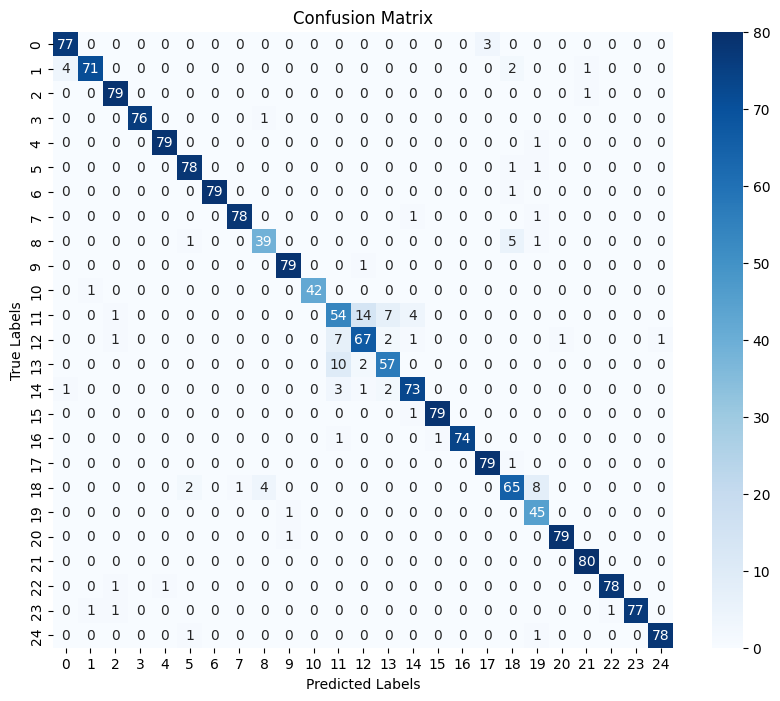

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        80
           1       0.97      0.91      0.94        78
           2       0.95      0.99      0.97        80
           3       1.00      0.99      0.99        77
           4       0.99      0.99      0.99        80
           5       0.95      0.97      0.96        80
           6       1.00      0.99      0.99        80
           7       0.99      0.97      0.98        80
           8       0.89      0.85      0.87        46
           9       0.98      0.99      0.98        80
          10       1.00      0.98      0.99        43
          11       0.72      0.68      0.70        80
          12       0.79      0.84      0.81        80
          13       0.84      0.83      0.83        69
          14       0.91      0.91      0.91        80
          15       0.99      0.99      0.99        80
          16       1.00      0.97      0.99        76
          17       0.96    

In [18]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

y_pred = model.predict(validation_aug)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = validation_aug.classes

# Generate confusion matrix
confusion_mat = confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report = classification_report(true_categories, predicted_categories)
print(classification_report)

### ROC Curve

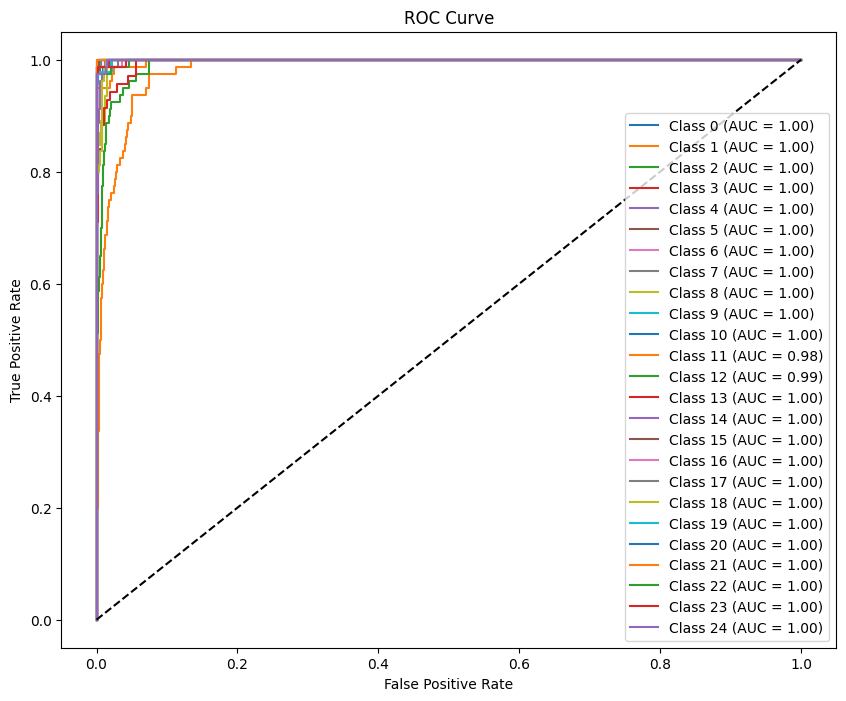

In [20]:
from sklearn.metrics import roc_curve, auc

# Generate predictions
y_pred = model.predict(validation_aug)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the true labels from the validation generator
y_true = validation_aug.labels

# Convert the true labels to one-hot encoded format
n_classes = validation_aug.num_classes
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# Compute ROC curve and ROC AUC for each class
for i in range(n_classes):
    # Compute the ROC curve and store the false positive rate (fpr), true positive rate (tpr), and thresholds (_)
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])

    # Compute the ROC AUC using the false positive rate (fpr) and true positive rate (tpr)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    # Plot the ROC curve for the current class, and label it with the class index and the corresponding ROC AUC
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the random classifier line (diagonal line from bottom-left to top-right)
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Display legend
plt.legend(loc='lower right')

# Show the plot
plt.show()